# Impor Libraries

In [1]:
# Reload modulos automaticamente
%load_ext autoreload
%autoreload 2
from modules.gnn import GNN
from modules.models import GraphSAGE, GCN
from modules.predictors import DotPredictor, MLPPredictor
import torch.nn.functional as F
from torch.optim import Adam
import itertools
import dgl
import torch
import matplotlib.pyplot as plt
from utils import *
from modules.graph import Graph
import numpy as np
import os



/home/vale/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#FIXME: el edge (1,2) es equivalente a (2,1)), es importante asegurarse de que ambos casos se asignen al mismo conjunto (entrenamiento, validación o prueba). La implementación actual, sin embargo, no garantiza esto.
#FIXME: Entrenamiento con unicamente nodos, areglar varanza (long tail) y normalizar 
#FIXME: porq me esta dando la validacion eso, ver ambos lados como se infieren???

# Caso 1: 
    * Model :GraphSAGE
    * Features : Todos 
    * Predictor : DotProduct
    

In [2]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[TOPOLOGÍA] Graph with 74145 nodes and 461889 edges
Graph with 46720 nodes and 434464 edges
Graph with 46243 nodes and 433987 edges
Graph with 46235 nodes and 433979 edges


Done loading data from cached files.
None
Training edges: 86838
Validation edges: 173511
Test edges: 173630
In epoch 0, train loss: 0.7160577774047852, val loss: 0.7156169414520264
In epoch 10, train loss: 0.6863246560096741, val loss: 0.6865925192832947
In epoch 20, train loss: 0.6815794706344604, val loss: 0.6818476319313049
In epoch 30, train loss: 0.6768614053726196, val loss: 0.6773364543914795
In epoch 40, train loss: 0.6711758375167847, val loss: 0.6717228889465332
In epoch 50, train loss: 0.6637986302375793, val loss: 0.6645487546920776
In epoch 60, train loss: 0.6557663083076477, val loss: 0.6568842530250549
In epoch 70, train loss: 0.6498330235481262, val loss: 0.6513197422027588
In epoch 80, train loss: 0.6453031301498413, val loss: 0.6470634341239929
In epoch 90, train loss: 0.641308605670929, val loss: 0.6431933045387268


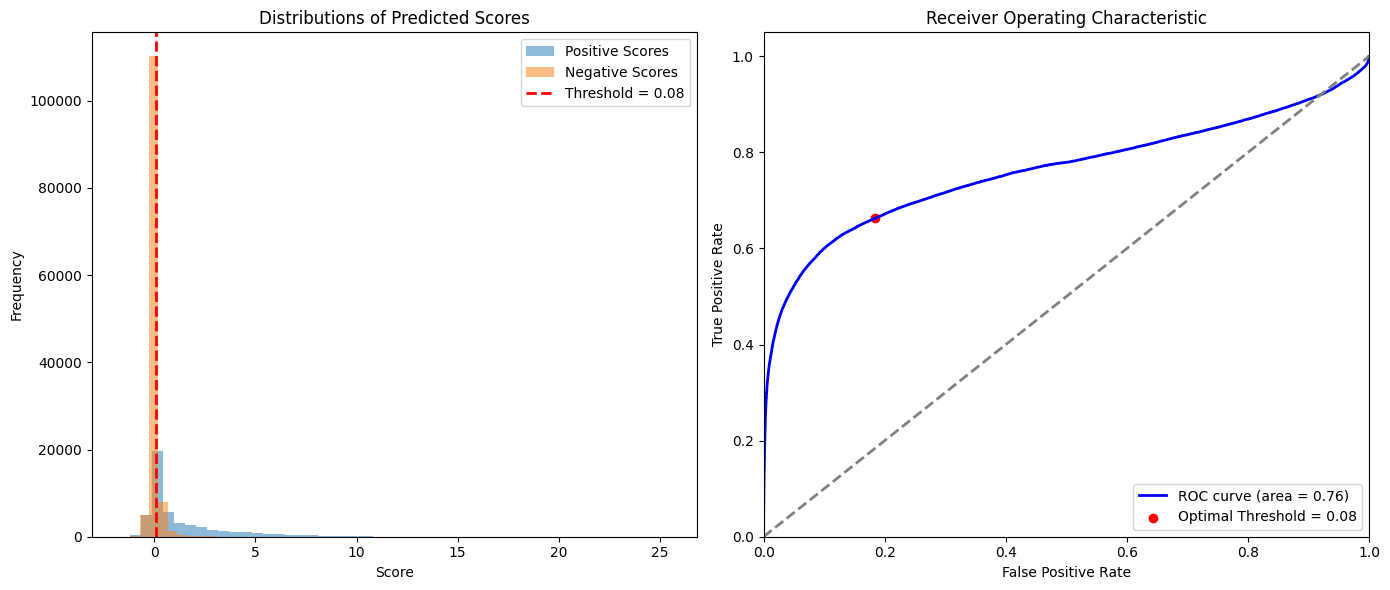

AUC: 0.7631607286542517


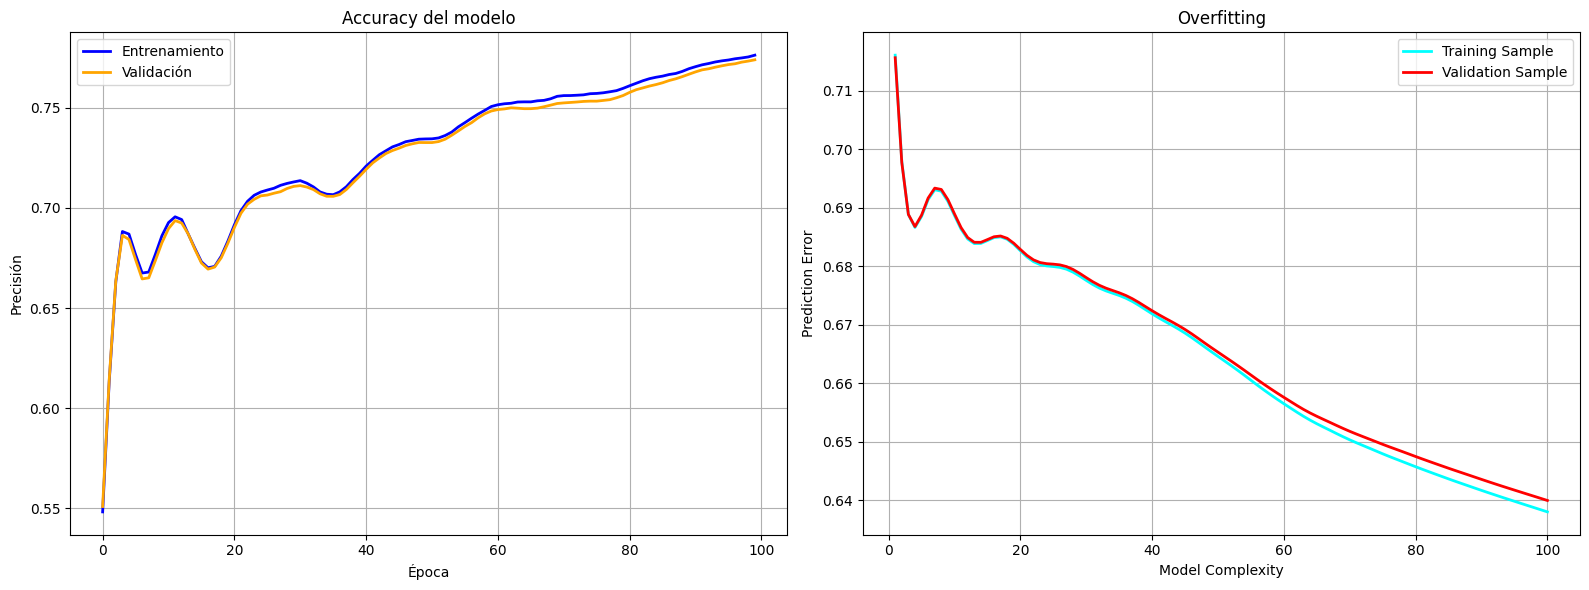

In [32]:
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset(0.2)
# gnn.split_dtaset_v2()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1
labels = gnn.dgl_graph.edata["Relationship"].float()
num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.001)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())
  
  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())


  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_train_scores = logits.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)




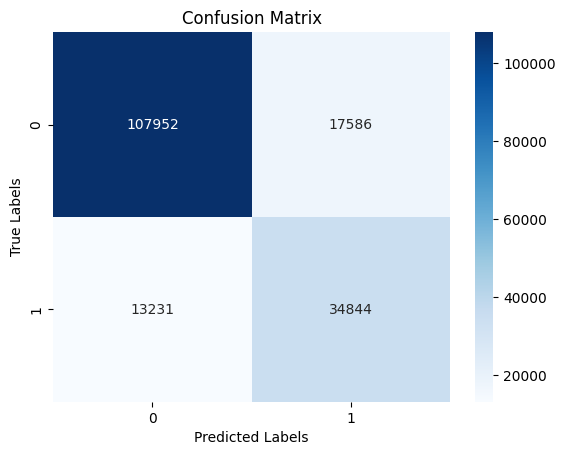

Classification Report:

              precision    recall  f1-score   support

           0     0.8908    0.8599    0.8751    125538
           1     0.6646    0.7248    0.6934     48075

    accuracy                         0.8225    173613
   macro avg     0.7777    0.7923    0.7842    173613
weighted avg     0.8282    0.8225    0.8248    173613



In [4]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 2: 
    * Model :GraphSAGE
    * Features : ALL
    * Predictor : MLPPredictor
    

In [3]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
# Path de donde se guardaran archivos
path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "/home/vale/Desktop/GIT/TESIS/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename)

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[TOPOLOGÍA] Graph with 74145 nodes and 461889 edges
Graph with 46720 nodes and 434464 edges
Graph with 46243 nodes and 433987 edges
Graph with 46235 nodes and 433979 edges


Done loading data from cached files.
None
Training edges: 260324
Validation edges: 86690
Test edges: 86965
In epoch 0, train loss: 0.6901584267616272, val loss: 0.6901469230651855
In epoch 10, train loss: 0.35792991518974304, val loss: 0.3583177924156189
In epoch 20, train loss: 0.21982428431510925, val loss: 0.21905115246772766
In epoch 30, train loss: 0.1848217248916626, val loss: 0.18368665874004364
In epoch 40, train loss: 0.1556759625673294, val loss: 0.15483511984348297
In epoch 50, train loss: 0.14485935866832733, val loss: 0.14449895918369293
In epoch 60, train loss: 0.134857177734375, val loss: 0.13543358445167542
In epoch 70, train loss: 0.12841477990150452, val loss: 0.1293034702539444


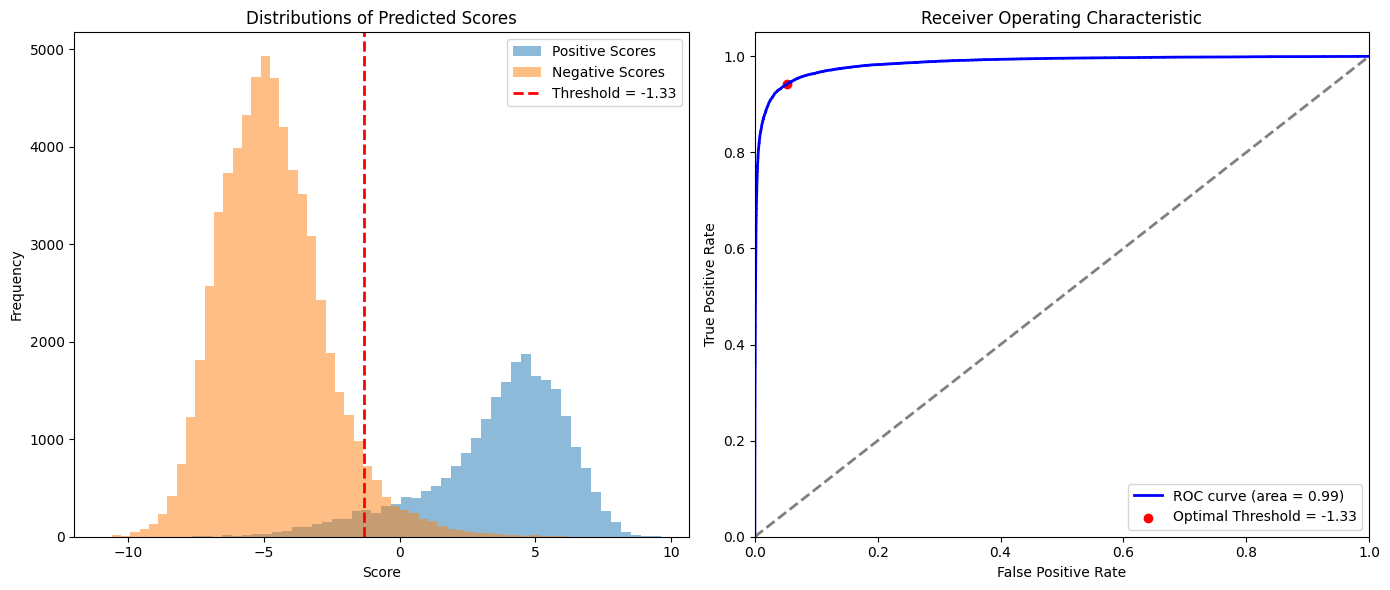

AUC: 0.9856155001723145


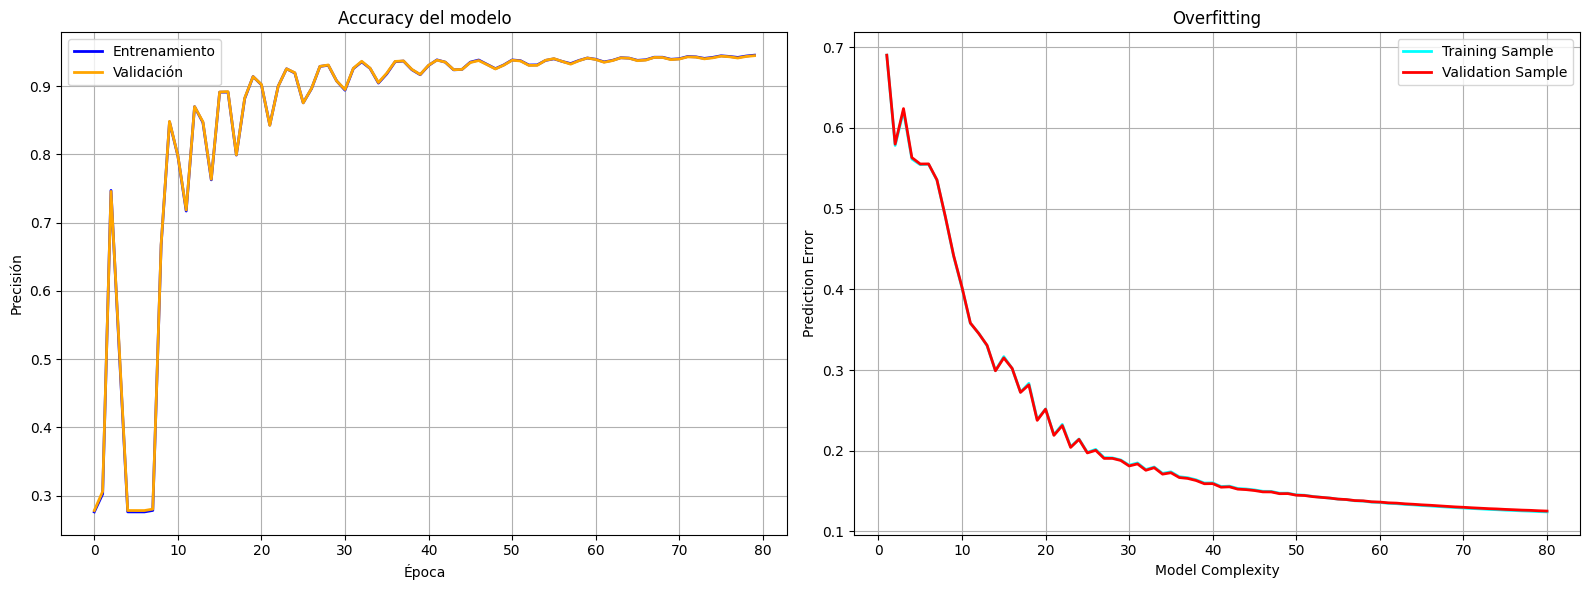

In [40]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.02)

# ----------- 4. training -------------------------------- #
# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []
for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  

  # backward
  optimizer.zero_grad()
  # train_loss.backward()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_train_scores = logits.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


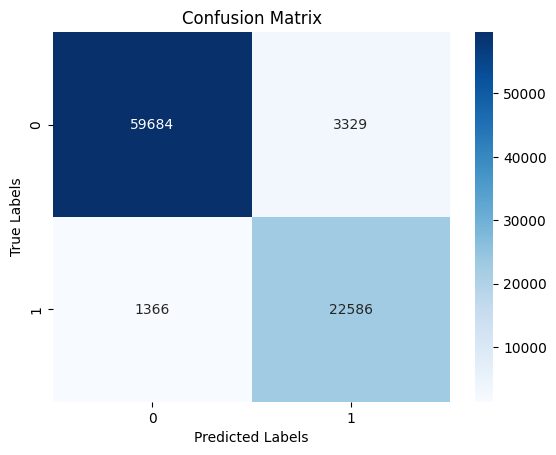

Classification Report:

              precision    recall  f1-score   support

           0     0.9776    0.9472    0.9622     63013
           1     0.8715    0.9430    0.9058     23952

    accuracy                         0.9460     86965
   macro avg     0.9246    0.9451    0.9340     86965
weighted avg     0.9484    0.9460    0.9466     86965



In [41]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

# Caso 3: 
    * Model :GraphSAGE
    * Features : in_degree y out_degree
    * Predictor : DotPredictor
    

In [42]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------
""" node_id,feat
 1,"10, 7"
 7843,"33, 54"

 """

path_dataset = os.getcwd() + "/datasets/DGL_Graph/MYCODEDiGraphDegree/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.only_degree_features_nodes(features_filename)

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges
[SAVE IN: /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEDiGraphDegree/nodes.csv]
DiGraph with 46720 nodes and 434464 edges
DiGraph with 46243 nodes and 433987 edges
DiGraph with 46235 nodes and 433979 edges


Done loading data from cached files.
None
Training edges: 261074
Validation edges: 86127
Test edges: 86778
In epoch 0, train loss: 26445.494140625, val loss: 26786.91796875
In epoch 10, train loss: 21219.953125, val loss: 21383.818359375
In epoch 20, train loss: 17711.34765625, val loss: 17768.443359375
In epoch 30, train loss: 14586.994140625, val loss: 14563.8740234375
In epoch 40, train loss: 11740.9755859375, val loss: 11646.1806640625
In epoch 50, train loss: 10541.32421875, val loss: 10436.8623046875
In epoch 60, train loss: 9714.7353515625, val loss: 9616.65234375
In epoch 70, train loss: 8905.2353515625, val loss: 8820.6396484375
In epoch 80, train loss: 8245.65625, val loss: 8180.49267578125
In epoch 90, train loss: 7726.271484375, val loss: 7675.94189453125


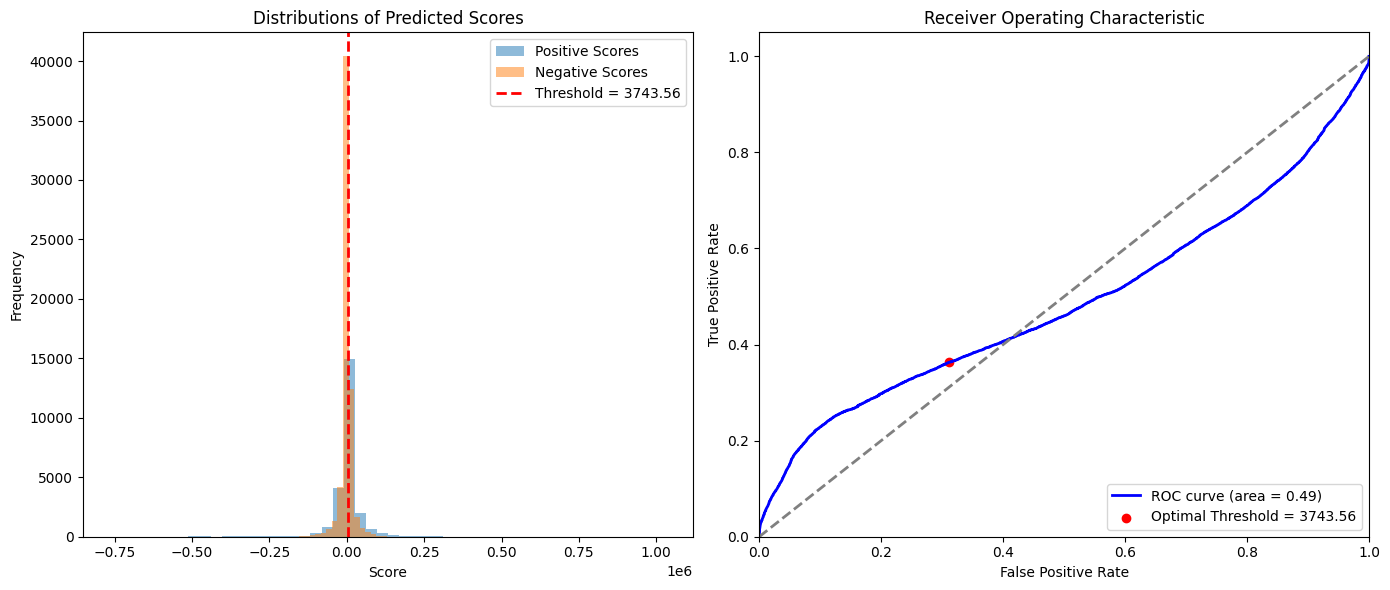

AUC: 0.488499062221524


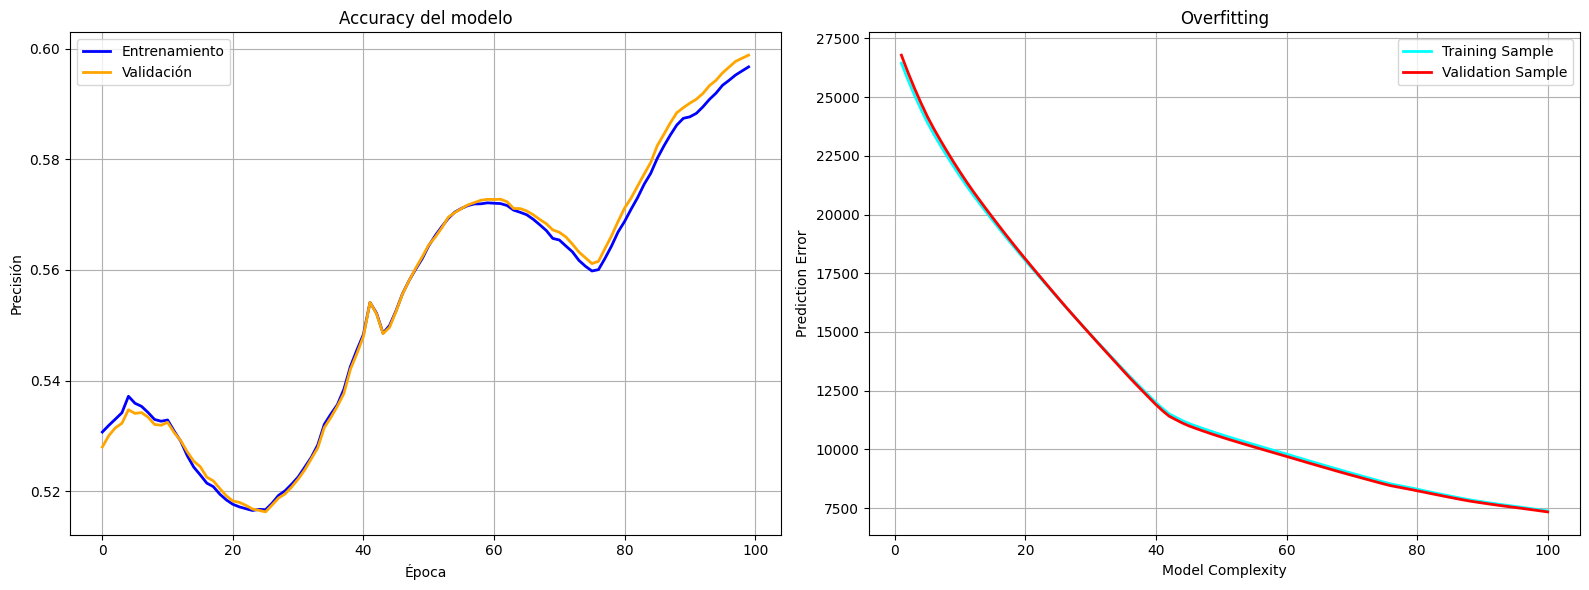

In [48]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
# print(gnn.dgl_graph.ndata['feat'] )

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.0005)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(100):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)

  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_train_scores = logits.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


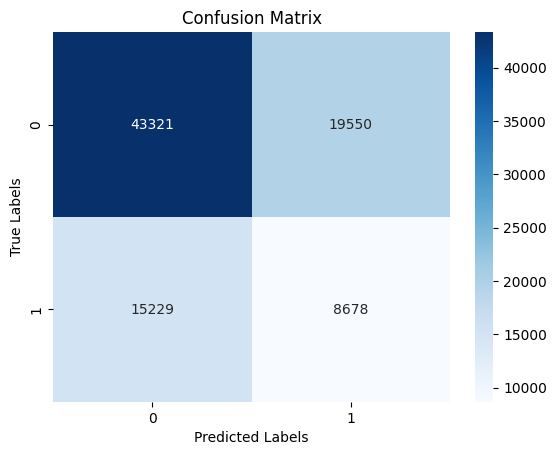

Classification Report:

              precision    recall  f1-score   support

           0     0.7399    0.6890    0.7136     62871
           1     0.3074    0.3630    0.3329     23907

    accuracy                         0.5992     86778
   macro avg     0.5237    0.5260    0.5232     86778
weighted avg     0.6208    0.5992    0.6087     86778



In [49]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)

### Antigua?

Done loading data from cached files.
None
Training edges: 260154
Validation edges: 86941
Test edges: 86884
tensor([[10.,  7.],
        [15.,  3.],
        [21.,  2.],
        ...,
        [ 2.,  0.],
        [ 2., 12.],
        [ 1.,  0.]])
In epoch 0, loss: 2244174.0
In epoch 10, loss: 303663.78125
In epoch 20, loss: 185992.125
In epoch 30, loss: 46142.75
In epoch 40, loss: 33266.9453125
In epoch 50, loss: 21983.197265625
In epoch 60, loss: 13389.4130859375
In epoch 70, loss: 10462.1298828125
In epoch 80, loss: 8364.8212890625
In epoch 90, loss: 6811.30126953125
In epoch 100, loss: 5748.82568359375
In epoch 110, loss: 4844.896484375
In epoch 120, loss: 4136.1943359375
In epoch 130, loss: 3564.01123046875
In epoch 140, loss: 3090.1748046875
In epoch 150, loss: 2641.63330078125
In epoch 160, loss: 2188.367919921875
In epoch 170, loss: 1756.885009765625
In epoch 180, loss: 1463.996337890625
In epoch 190, loss: 1311.491943359375


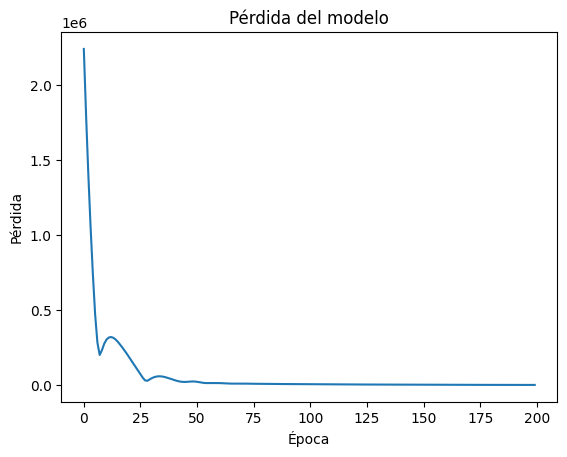

In [50]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraphDegree/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset()

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float() #FIXME:
print(gnn.dgl_graph.ndata['feat'] )

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 15
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, num_feat_out)
pred = DotPredictor()

# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #

# Lista para almacenar los valores de pérdida
loss_values = []

for e in range(200):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  scores =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

#   # print("[LABELS]",labels)
#   # print("[SCORES]",scores)
  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  loss_values.append(loss.item())

  # backward
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if e % 10 == 0:
    print('In epoch {}, loss: {}'.format(e, loss))
    # scores_numpy = numpyscores.numpy()

    # print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}') #NO PODER DETACH!!!!!!!!!!!!!!
# print(f'AUC {roc_auc_score(labels.detach().numpy(), scores.detach().numpy())}')

plt.plot(loss_values)
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.show()


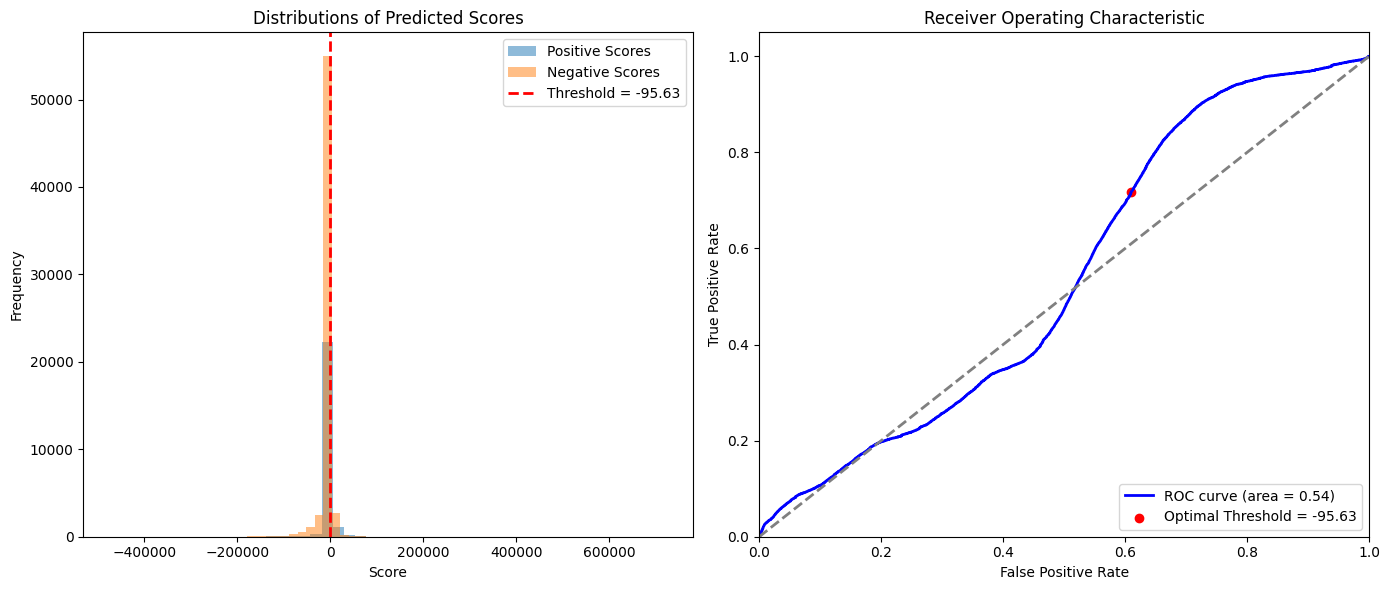

AUC: 0.5388083670489288


NameError: name 'cal_acc_pres_f1' is not defined

In [51]:
true_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_scores = scores.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_labels,predicted_scores)
cal_acc_pres_f1(predicted_scores,true_labels, threshold=optimal_threshold)

# Caso 4: 
    * Model :GraphSAGE
    * Features : ['AS_rank_continent','peeringDB_info_ratio','peeringDB_info_scope','peeringDB_info_type','peeringDB_policy_general' 'ASDB_C1L1', 'AS_rank_numberAsns', 'AS_rank_customer', 'AS_rank_peer', 'peeringDB_ix_count', 'peeringDB_fac_count', 'cti_top']
    * Predictor : MLPPredictor

In [16]:
# Crea archivos creacion dataset train, test, val -----------------------------------------------------

LIST_FEATURES_NO_CATEG = ['AS_rank_numberAsns', 'AS_rank_customer', 'peeringDB_fac_count', 'cti_top']

LIST_FEATURES_CATEG = ['AS_rank_continent',
                        # 'peeringDB_info_ratio',
                        # 'peeringDB_info_scope',
                        # 'peeringDB_info_type',
                        # 'peeringDB_policy_general'
                        'ASDB_C1L1'
                        ]

# Crear Di graph 
list_feat = LIST_FEATURES_NO_CATEG + LIST_FEATURES_CATEG
path_dataset = os.getcwd() +  "/datasets/DGL_Graph/MYCODEDiGraph/"  
graph = Graph(path_dataset, debug=True)

# 1.- Creo topologia dataset y label 
type = "DiGraph"  # o "MultiDiGraph"
file_path = "datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"  # Path archivos Relationships para creacion de topologia y etiquetado
graph.read_from_relationship_edgelist(file_path,type)
print("[TOPOLOGÍA]", graph.nx_graph)

# # 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat)

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)

[TOPOLOGÍA] DiGraph with 74145 nodes and 461889 edges
DiGraph with 46720 nodes and 434464 edges
DiGraph with 46243 nodes and 433987 edges
DiGraph with 46235 nodes and 433979 edges


Done loading data from cached files.
None
Training edges: 260719
Validation edges: 86603
Test edges: 86657
In epoch 0, train loss: 0.8605502843856812, val loss: 0.8610250353813171
In epoch 10, train loss: 0.5051819682121277, val loss: 0.5044810175895691
In epoch 20, train loss: 0.26341718435287476, val loss: 0.2670234739780426
In epoch 30, train loss: 0.2134564071893692, val loss: 0.21571409702301025
In epoch 40, train loss: 0.169789120554924, val loss: 0.17036783695220947
In epoch 50, train loss: 0.15520119667053223, val loss: 0.1547391712665558
In epoch 60, train loss: 0.141002357006073, val loss: 0.1404685229063034
In epoch 70, train loss: 0.1342485398054123, val loss: 0.13382013142108917


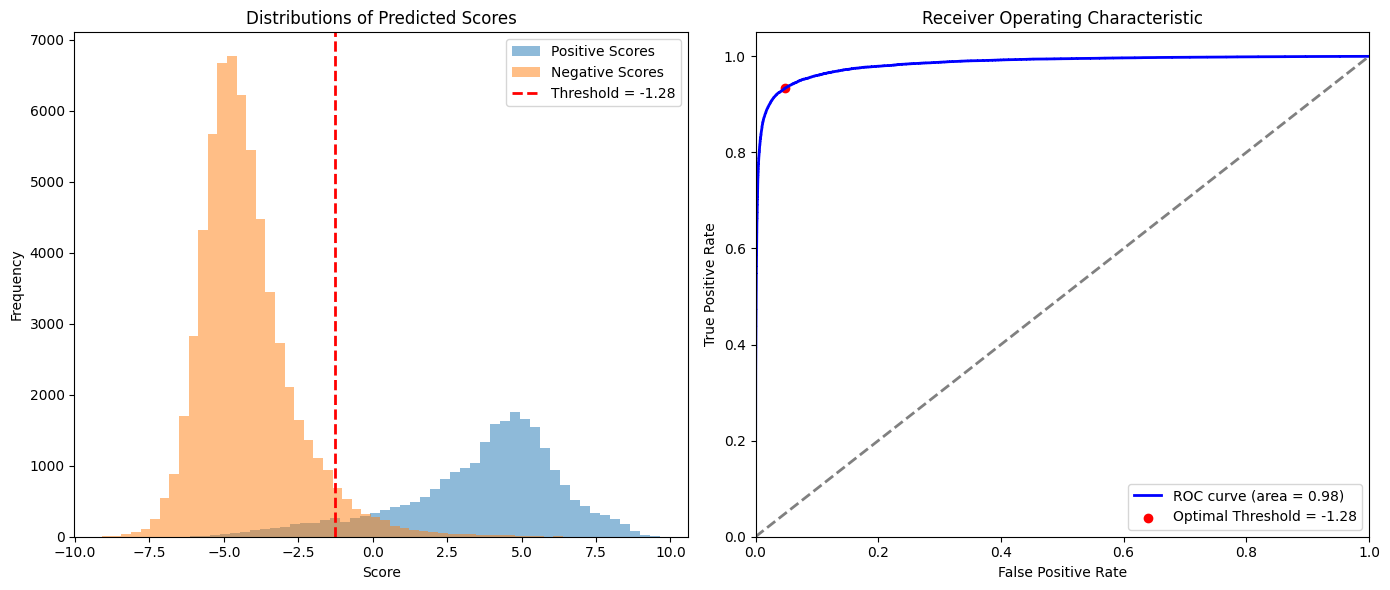

AUC: 0.9840653936662531


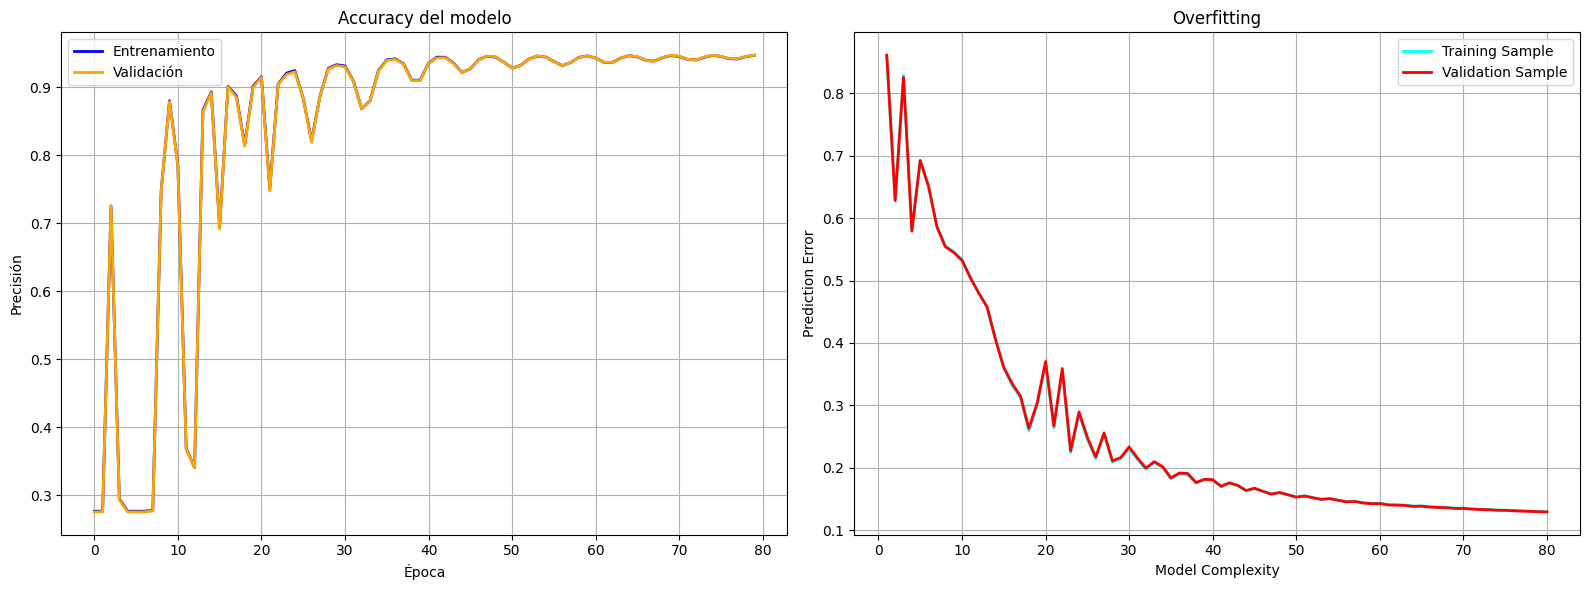

In [52]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEDiGraph/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.0)

# ----------- 4. training -------------------------------- #
# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)


  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_train_scores = logits.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)


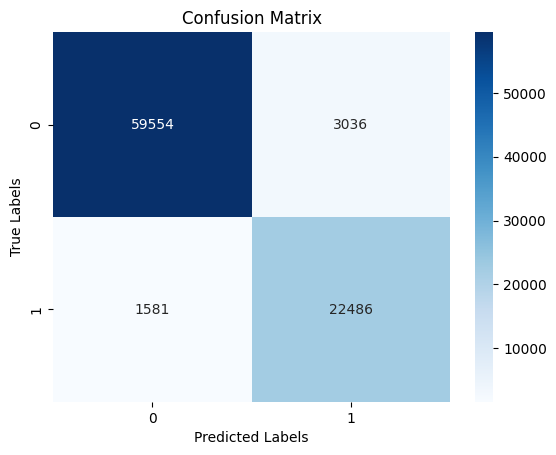

Classification Report:

              precision    recall  f1-score   support

           0     0.9741    0.9515    0.9627     62590
           1     0.8810    0.9343    0.9069     24067

    accuracy                         0.9467     86657
   macro avg     0.9276    0.9429    0.9348     86657
weighted avg     0.9483    0.9467    0.9472     86657



In [53]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)


# Caso 5:
    * Model : ???
    * Features : ???
    * Predictor : ???
Se crea un grafo a partir de un collector de RIPE NCC y ver si este generaliza para otro grafos

In [ ]:
# Descargar grafo de BGPStream
#DEMORA HARTO

# df = download_graph_create_edges_csv("2022-06-01 00:00:00", "2022-06-01 00:15:00", ["rrc00"], "ribs", "graph-2022-06-rrc00-ribs", directed=False)
# print(df)

In [26]:
# Etiquetar grafo con CAIDA AS Relationships 
# Cargar el grafo desde el archivo .dgl


#Comprobando que se creo bien el grafo FIXME:
# import os
# import dgl
# import networkx as nx
# path = os.getcwd() + "/datasets/ROUTE_COLLECTORS/AS_GRAPH_NO_DIRIGIDO.dgl"
# graphs, _ = dgl.load_graphs(path)
# print(graphs)
# # [Graph(num_nodes=79957, num_edges=441580,
# #       ndata_schemes={}
# #       edata_schemes={})]


# path = "datasets/ROUTE_COLLECTORS/Downloads/graph-2022-06-rrc00-ribs-edges.csv"
# print(path)
# g = nx.read_edgelist(path, delimiter=',', nodetype=int, comments='src_id,dst_id')
# print(g)

[Graph(num_nodes=79957, num_edges=441580,
      ndata_schemes={}
      edata_schemes={})]


In [ ]:
list_feat = "all"


In [35]:
# Crear Archivos nodes.csv y edges.csv 

# Etiquetar edges.csv con CAIDA AS Relationships
file_csv = os.getcwd()+ "/datasets/ROUTE_COLLECTORS/Downloads/graph-2022-06-rrc00-ribs-edges.csv"
filename_caida = os.getcwd()+ "/datasets/CAIDA_AS_Relationships/Serial_2/20220701.as-rel2.txt.bz2"
graph = Graph(os.getcwd()+"/datasets/DGL_Graph/MYCODEGraphRRC00/", debug=True)
graph.label_edgelist(filename_caida,file_csv,type="DiGraph")

# Agregar atributos para cada AS
# 2.- Creo archivo nodes.csv con las features de los nodos que se van a aocupar y lo agrego a  dataset_dic de la clase
features_filename = "datasets/GNN_INTERNET_DATA/node_features.csv"
graph.features_nodes(features_filename,list_feat="all")

# 3.- Eliminar nodos de grado 1 hojas

graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)
graph.remove_nodes_degree(1)



[Tamaño df_edges_labeless: (220910, 3)]
Creando archivo edges.csv
[SAVE : /home/vale/Desktop/GIT/TESIS/datasets/DGL_Graph/MYCODEGraphRRC00/edges.csv]
DiGraph with 74145 nodes and 461889 edges
DiGraph with 46720 nodes and 434464 edges
DiGraph with 46243 nodes and 433987 edges
DiGraph with 46235 nodes and 433979 edges


Done loading data from cached files.
None
Training edges: 260184
Validation edges: 87006
Test edges: 86789
In epoch 0, train loss: 0.7680838704109192, val loss: 0.7679205536842346
In epoch 10, train loss: 0.4542924165725708, val loss: 0.4556022584438324
In epoch 20, train loss: 0.2122344970703125, val loss: 0.21373577415943146
In epoch 30, train loss: 0.1725320965051651, val loss: 0.17111612856388092
In epoch 40, train loss: 0.14863912761211395, val loss: 0.1470687985420227
In epoch 50, train loss: 0.13904283940792084, val loss: 0.13837292790412903
In epoch 60, train loss: 0.12907640635967255, val loss: 0.12843994796276093
In epoch 70, train loss: 0.12380658090114594, val loss: 0.12335424870252609


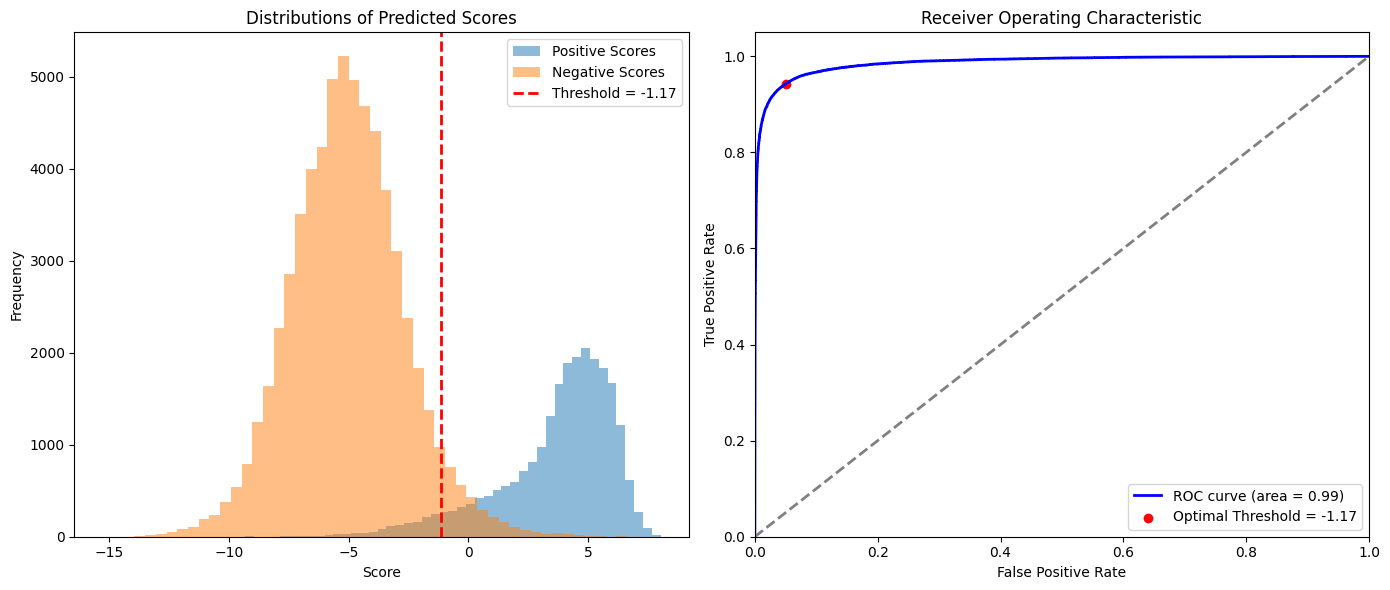

AUC: 0.986531388831725


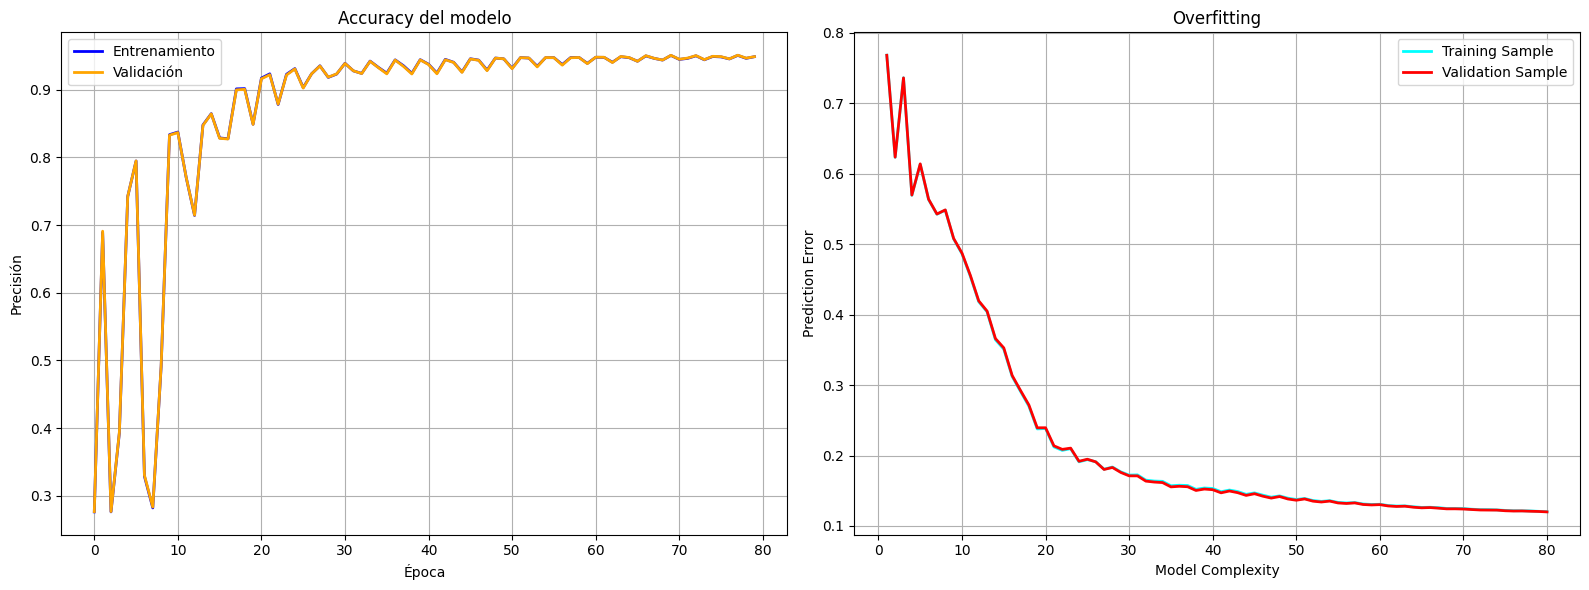

In [54]:
# dataset con features de nodos unicamente degrees
data_path = "datasets/DGL_Graph/MYCODEGraphRRC00/"

gnn = GNN(debug=True)
gnn.load_dataset( data_path, force_reload=False)
gnn.split_dataset(0.6)

gnn.dgl_graph.ndata['feat'] = gnn.dgl_graph.ndata['feat'].float()

edge_label = gnn.dgl_graph.edata['Relationship']
train_mask = gnn.train_mask
test_mak = gnn.test_mask

in_feats = gnn.dgl_graph.ndata["feat"].size(1) #72
h_feats = 16
num_clases = 1

num_features_in =  gnn.dgl_graph.ndata["feat"].size(1)
num_feat_hidden = 16
num_feat_out = 1

# model = GraphSAGE(num_features_in, num_feat_hidden,num_feat_out)
model = GraphSAGE(num_features_in, num_feat_hidden, 8)
pred = MLPPredictor(8,1)


# ----------- 3. set up loss and optimizer -------------- #

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.05)

# ----------- 4. training -------------------------------- #
# Lista para almacenar los valores de pérdida
model_complexity = []

acc_val = []
acc_train = []

train_error = []
val_error = []

for e in range(80):
  # forward
  h = model(gnn.dgl_graph, gnn.dgl_graph.ndata['feat'])
  logits =  pred(gnn.dgl_graph, h)
  labels = gnn.dgl_graph.edata["Relationship"].float()

  loss = F.binary_cross_entropy_with_logits(scores[train_mask], labels[train_mask])

  # Calculo pérdida --------------------------------------------------------
  # Calcular la pérdida en el conjunto de entrenamiento --------------------
  train_loss = F.binary_cross_entropy_with_logits(logits[train_mask], labels[train_mask])
  train_error.append(train_loss.item())


  # Calcular la pérdida en el conjunto de validación -----------------------
  val_loss = F.binary_cross_entropy_with_logits(logits[gnn.val_mask], labels[gnn.val_mask])
  val_error.append(val_loss.item())

  # Calculo accuracy -------------------------------------------------------
  # Calcular la precisión en el conjunto de entrenamiento
  train_acc = logits[train_mask]

  # Calcular la precisión en el conjunto de validación
  val_acc = logits[gnn.val_mask] 

  # Guardar los valores de precisión
  acc_train.append(train_acc)
  acc_val.append(val_acc)


  # Guardar la complejidad (epochs) del modelo (aquí usamos el número de épocas)
  model_complexity.append(e + 1)

  # backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  if e % 10 == 0:
      print('In epoch {}, train loss: {}, val loss: {}'.format(e, train_loss, val_loss))

# ----------- 5. Definir threashold -------------- #

true_train_labels = gnn.dgl_graph.edata["Relationship"][test_mak]
predicted_train_scores = logits.detach().numpy()[test_mak]
optimal_threshold = plot_roc_curve(true_train_labels,predicted_train_scores)


# ----------- 6. plot the loss and accuracy de training-------------- #

plot_training(gnn,train_error,acc_train,val_error,acc_val,model_complexity,optimal_threshold)

In [ ]:
# TODO: Importar segundo dataset para el test

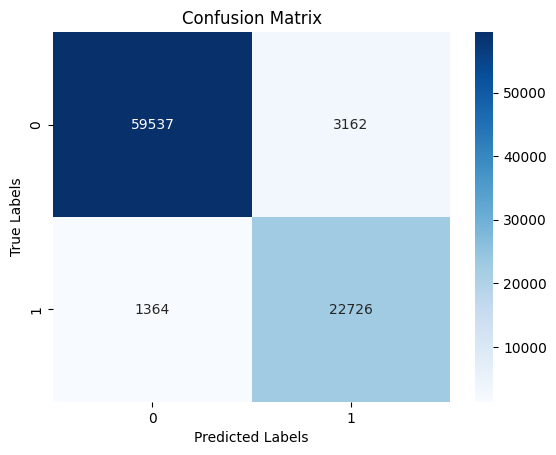

Classification Report:

              precision    recall  f1-score   support

           0     0.9776    0.9496    0.9634     62699
           1     0.8779    0.9434    0.9094     24090

    accuracy                         0.9479     86789
   macro avg     0.9277    0.9465    0.9364     86789
weighted avg     0.9499    0.9479    0.9484     86789



In [55]:
# ----------- 6. Calcular métricas -------------- #

calculate_metrics(predicted_train_scores,true_train_labels, threshold=optimal_threshold)